In [11]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms as tt
import torchvision
from torchsummary import summary

import random
import numpy as np
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

np.random.seed(4)
from tabulate import tabulate

# Dataset and Dataloader

In [12]:
dataset_folder_name = "./UTKFace"
IM_WIDTH = IM_HEIGHT = 224

In [13]:
dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        #0: 'male',
        #1: 'female'
        0: 0,
        1: 1
    }
}

In [14]:
dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())

Creating Utility function for readinng data


In [15]:
def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')            
            return int(age), int(dataset_dict['gender_id'][int(gender)]), dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None

In [16]:
def parse_dataset(dataset_path, ext='jpg'):     
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

Creating Custom datset class

In [17]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""

    def __init__(self,df, transform=None):
        self.img_names = df['file'].values
        self.y = df['gender'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.img_names[index])

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

In [18]:
df = parse_dataset(dataset_folder_name)

age = df['age'].values
age_categories = []
for i in tqdm(range(len(age))):
    if age[i]<=28:
        age_categories.append('children')
    elif 28<age[i]<=56:
        age_categories.append('young')
    elif 56<age[i]<=84:
        age_categories.append('adult')
    else:
        age_categories.append('old')
df['age_categories'] = age_categories  

## Spliting dataset into train and test
train, test = train_test_split(df, test_size=0.2)
img = Image.open(df['file'][0])

100%|██████████| 23705/23705 [00:00<00:00, 755470.61it/s]


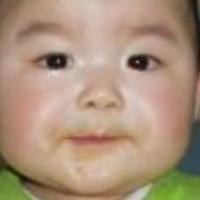

In [19]:
img

In [20]:
df

,age,gender,race,file,age_categories
0,1.0,0.0,asian,./UTKFace/1_0_2_20161219200203132.jpg.chip.jpg,children
1,15.0,0.0,white,./UTKFace/15_0_0_20170116201342325.jpg.chip.jpg,children
2,28.0,0.0,black,./UTKFace/28_0_1_20170109012501213.jpg.chip.jpg,children
3,63.0,0.0,white,./UTKFace/63_0_0_20170104213553685.jpg.chip.jpg,adult
4,17.0,0.0,white,./UTKFace/17_0_0_20170104011953696.jpg.chip.jpg,children
...,...,...,...,...,...
23703,26.0,0.0,asian,./UTKFace/26_0_2_20170116181100669.jpg.chip.jpg,children
23704,19.0,1.0,black,./UTKFace/19_1_1_20170113012937783.jpg.chip.jpg,children
23705,34.0,0.0,white,./UTKFace/34_0_0_20170116232429422.jpg.chip.jpg,young
23706,25.0,1.0,indian,./UTKFace/25_1_3_20170104232025362.jpg.chip.jpg,children


In [12]:
custom_transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])
train_data = UTKFaceDataset(train,custom_transform)
test_data = UTKFaceDataset(test,custom_transform)

# Classification using LCNN model (9 Conv layer version)

In [11]:
class mfm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, type=1):
        super(mfm, self).__init__()
        self.out_channels = out_channels
        if type == 1:
            self.filter = nn.Conv2d(in_channels, 2*out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        else:
            self.filter = nn.Linear(in_channels, 2*out_channels)

    def forward(self, x):
        x = self.filter(x)
        out = torch.split(x, self.out_channels, 1)
        return torch.max(out[0], out[1])

class group(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(group, self).__init__()
        self.conv_a = mfm(in_channels, in_channels, 1, 1, 0)
        self.conv   = mfm(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.conv_a(x)
        x = self.conv(x)
        return x

class resblock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(resblock, self).__init__()
        self.conv1 = mfm(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = mfm(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        res = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + res
        return out

class network_9layers(nn.Module):
    def __init__(self, num_classes=79077):
        super(network_9layers, self).__init__()
        self.features = nn.Sequential(
            mfm(3, 48, 5, 1, 2), 
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True), 
            group(48, 96, 3, 1, 1), 
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            group(96, 192, 3, 1, 1),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True), 
            group(192, 128, 3, 1, 1),
            group(128, 128, 3, 1, 1),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            )
        self.fc1 = mfm(25088, 256, type=0)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.dropout(x, training=self.training)
        out = self.fc2(x)
        return out, x

In [12]:
def get_device():
    return torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

In [69]:
class Network():   
    model = None 
    def __init__(self):
        self.model = network_9layers()
        self.model.to(get_device())
           
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
          _, predictions = torch.max(outputs, dim=1)
          return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def _process_batch(self, batch):
        images, labels = batch
        outputs,_ = self.model(images)
        labels = torch.tensor(labels, dtype=torch.long, device=device)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)

    def fit(self, dataset, epochs, lr, batch_size, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        history = []

        for epoch in range(epochs):
          losses = []
          accs = []
          for batch in tqdm(dataloader):
            loss, acc = self._process_batch(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss.detach()
            losses.append(loss)
            accs.append(acc)
          avg_loss = torch.stack(losses).mean().item()
          avg_acc = torch.stack(accs).mean().item()
          history.append((avg_loss, avg_acc))
          print('After Epoch  {}, train_loss = {},  train_acc = {}\n'.format(epoch+1, round(avg_loss, 4),round(avg_acc, 4)))
        return history

    def evaluate(self, dataset, batch_size=32):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
          for batch in dataloader:
            loss, acc= self._process_batch(batch)
            losses.append(loss)
            accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc) 
    
    def getPrediction(self, dataset, batch_size=32):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        prediction = []
        with torch.no_grad():
          for batch in tqdm(dataloader):
            images, labels = batch
            outputs,_ = self.model(images)
            _, outputs = torch.max(outputs, dim=1)
            prediction = prediction + list(outputs)
        return prediction
                

            

In [14]:
net = Network()
batch_size = 32
epochs = 50
lr = 2e-2
device = get_device()
history = net.fit(train_data, epochs, lr, batch_size, opt=torch.optim.SGD)


  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  1, train_loss = 0.6906,  train_acc = 0.5266



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  2, train_loss = 0.6271,  train_acc = 0.6582



  0%|          | 1/593 [00:00<01:30,  6.55it/s]

After Epoch  3, train_loss = 0.5471,  train_acc = 0.7223



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  4, train_loss = 0.4363,  train_acc = 0.7987



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  5, train_loss = 0.3594,  train_acc = 0.8409



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  6, train_loss = 0.3163,  train_acc = 0.8612



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  7, train_loss = 0.2907,  train_acc = 0.8731



  0%|          | 1/593 [00:00<01:42,  5.80it/s]

After Epoch  8, train_loss = 0.2719,  train_acc = 0.8835



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  9, train_loss = 0.2581,  train_acc = 0.8911



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  10, train_loss = 0.2437,  train_acc = 0.8966



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  11, train_loss = 0.2308,  train_acc = 0.9055



  0%|          | 1/593 [00:00<01:24,  7.01it/s]

After Epoch  12, train_loss = 0.2185,  train_acc = 0.9102



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  13, train_loss = 0.2052,  train_acc = 0.9185



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  14, train_loss = 0.1932,  train_acc = 0.9243



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  15, train_loss = 0.1859,  train_acc = 0.927



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  16, train_loss = 0.1694,  train_acc = 0.9336



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  17, train_loss = 0.1571,  train_acc = 0.9401



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  18, train_loss = 0.1455,  train_acc = 0.9464



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  19, train_loss = 0.1365,  train_acc = 0.9476



  0%|          | 1/593 [00:00<01:43,  5.75it/s]

After Epoch  20, train_loss = 0.1236,  train_acc = 0.9537



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  21, train_loss = 0.1137,  train_acc = 0.9586



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  22, train_loss = 0.1016,  train_acc = 0.9617



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  23, train_loss = 0.0945,  train_acc = 0.9663



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  24, train_loss = 0.0848,  train_acc = 0.9705



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  25, train_loss = 0.0745,  train_acc = 0.9737



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  26, train_loss = 0.0688,  train_acc = 0.9762



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  27, train_loss = 0.0632,  train_acc = 0.9783



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  28, train_loss = 0.0566,  train_acc = 0.9798



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  29, train_loss = 0.0532,  train_acc = 0.9819



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  30, train_loss = 0.0496,  train_acc = 0.9832



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  31, train_loss = 0.0414,  train_acc = 0.9851



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  32, train_loss = 0.0417,  train_acc = 0.9875



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  33, train_loss = 0.0362,  train_acc = 0.9882



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  34, train_loss = 0.0382,  train_acc = 0.9891



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  35, train_loss = 0.0318,  train_acc = 0.9901



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  36, train_loss = 0.0291,  train_acc = 0.9918



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  37, train_loss = 0.0301,  train_acc = 0.9916



  0%|          | 1/593 [00:00<01:42,  5.79it/s]

After Epoch  38, train_loss = 0.0286,  train_acc = 0.9928



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  39, train_loss = 0.0251,  train_acc = 0.9936



  0%|          | 1/593 [00:00<01:42,  5.80it/s]

After Epoch  40, train_loss = 0.0282,  train_acc = 0.9922



  0%|          | 1/593 [00:00<01:50,  5.38it/s]

After Epoch  41, train_loss = 0.021,  train_acc = 0.9952



  0%|          | 1/593 [00:00<01:51,  5.32it/s]

After Epoch  42, train_loss = 0.0224,  train_acc = 0.9947



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  43, train_loss = 0.0236,  train_acc = 0.9946



  0%|          | 1/593 [00:00<01:25,  6.93it/s]

After Epoch  44, train_loss = 0.0194,  train_acc = 0.9955



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  45, train_loss = 0.0197,  train_acc = 0.9963



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  46, train_loss = 0.021,  train_acc = 0.9952



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  47, train_loss = 0.0196,  train_acc = 0.9957



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  48, train_loss = 0.0181,  train_acc = 0.9963



  0%|          | 0/593 [00:00<?, ?it/s]

After Epoch  49, train_loss = 0.0216,  train_acc = 0.9957



100%|██████████| 593/593 [02:18<00:00,  4.27it/s]

After Epoch  50, train_loss = 0.0153,  train_acc = 0.9966



In [15]:
torch.save(net.model.state_dict(), 'LCNN_model_weights.pth')

In [70]:
net = Network()
net.model.load_state_dict(torch.load('LCNN_model_weights.pth'))

<All keys matched successfully>

In [20]:
LCNN_history = history

In [26]:
t = [i + 1 for i in range(len(LCNN_history))]
data1 = [LCNN_history[i][0] for i in range(len(LCNN_history))]
data2 = [LCNN_history[i][1] for i in range(len(LCNN_history))]

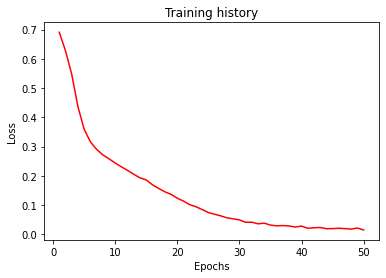

In [33]:
plt.plot(t, data1, color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training history')
plt.show()

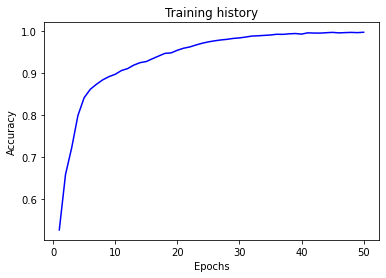

In [35]:
plt.plot(t, data2, color='b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training history')
plt.show()

## 1. Testing performance across all the age groups and race categories.

Testing Accuracy

In [55]:
_,acc = net.evaluate(test_data, batch_size=32)

In [56]:
print("Testing Accuracy : " , round(acc, 2))


Testing Accuracy :  0.89


In [71]:
prediction = net.getPrediction(test_data, batch_size=32)
prediction = [int(prediction[i]) for i in range(len(prediction))]

100%|██████████| 149/149 [00:46<00:00,  3.23it/s]


In [84]:
target = test['gender'].values
age_category = test['age_categories'].values
race_category = test['race'].values

In [86]:
np.unique(race_category)

array(['asian', 'black', 'indian', 'others', 'white'], dtype=object)

In [90]:
# Calculating accuracy across all age group
age_group = {'children':0,'adult':0,'young':0,'old':0}
age_group_total = {'children':0,'adult':0,'young':0,'old':0}

race_group = {'asian':0, 'black':0, 'indian':0, 'others':0, 'white':0}
race_group_total = {'asian':0, 'black':0, 'indian':0, 'others':0, 'white':0}

for i in range(len(target)):
    age_group_total[age_categories[i]] +=1
    race_group_total[race_category[i]] +=1
    
    if(target[i] == prediction[i]):
        age_group[age_categories[i]] +=1
        race_group[race_category[i]] +=1

In [106]:
data1 = []
for i in age_group.keys():
    temp = round(age_group[i]/age_group_total[i],2)
    data1.append([i,temp])
    
data2 = []
for i in race_group.keys():
    temp = round(race_group[i]/race_group_total[i],2)
    data2.append([i,temp])
    

In [107]:
print(tabulate(data1, headers=["Age Group", "Test Accuracy"]))

Age Group      Test Accuracy
-----------  ---------------
children                0.89
adult                   0.88
young                   0.9
old                     0.92


In [109]:
print(tabulate(data2, headers=["Race", "Test Accuracy"]))

Race      Test Accuracy
------  ---------------
asian              0.85
black              0.91
indian             0.91
others             0.9
white              0.89


## 2. ROC curve

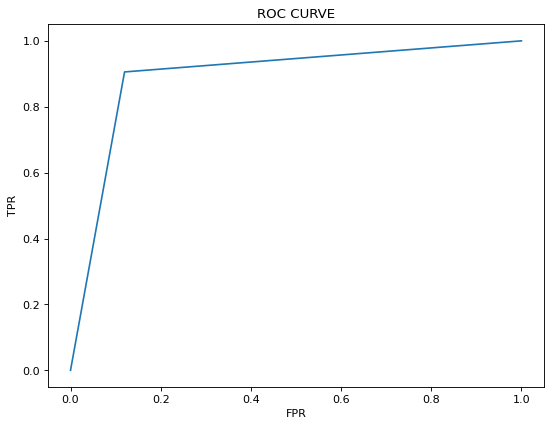

In [118]:

from sklearn.metrics import roc_curve
fpr, tpr, thresh1 = roc_curve(target, prediction, pos_label=1)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC CURVE')
plt.savefig('./ROC_CURVE')
plt.show()


## 3. Draw the Precision-Recall curve.


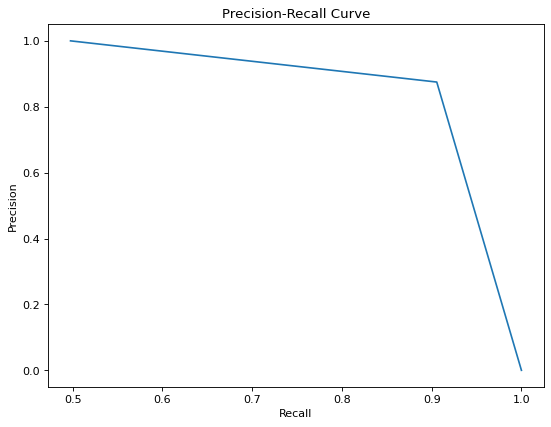

In [119]:
from  sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(prediction, target)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(precision,recall)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision-Recall Curve')
plt.savefig('./PRC_CURVE')
plt.show()

## 6. Change the loss function to focal loss for LCNN. Now compare the results with previous loss function that you have used ?

In [121]:
## Reference : https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
class Network():   
    model = None 
    def __init__(self):
        self.model = network_9layers()
        self.model.to(get_device())
           
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
          _, predictions = torch.max(outputs, dim=1)
          return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def _process_batch(self, batch):
        images, labels = batch
        outputs,_ = self.model(images)
        labels = torch.tensor(labels, dtype=torch.long, device=device)
        lossfun = FocalLoss()
        loss = lossfun.forward(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)

    def fit(self, dataset, epochs, lr, batch_size, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        history = []

        for epoch in range(epochs):
          losses = []
          accs = []
          for batch in tqdm(dataloader):
            loss, acc = self._process_batch(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss.detach()
            losses.append(loss)
            accs.append(acc)
          avg_loss = torch.stack(losses).mean().item()
          avg_acc = torch.stack(accs).mean().item()
          history.append((avg_loss, avg_acc))
          print('After Epoch  {}, train_loss = {},  train_acc = {}\n'.format(epoch+1, round(avg_loss, 4),round(avg_acc, 4)))
        return history

    def evaluate(self, dataset, batch_size=32):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
          for batch in dataloader:
            loss, acc= self._process_batch(batch)
            losses.append(loss)
            accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc) 
    
    def getPrediction(self, dataset, batch_size=32):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        prediction = []
        with torch.no_grad():
          for batch in tqdm(dataloader):
            images, labels = batch
            outputs,_ = self.model(images)
            _, outputs = torch.max(outputs, dim=1)
            prediction = prediction + list(outputs)
        return prediction

# Classification using Linear SVM

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score

from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [22]:
image_path = df['file'].values
num_sample = len(image_path)
x = []

for i in tqdm(range(len(image_path))):
    temp = Image.open(image_path[i]).convert('L')
    temp = np.array(temp)
    x.append(temp)
x = np.array(x)


100%|██████████| 23705/23705 [10:50<00:00, 36.45it/s]


In [23]:
x.shape

(23705, 200, 200)

In [25]:
n_samples = x.shape[0]
x = x.reshape((n_samples, -1))
x.shape

(23705, 40000)

In [28]:
y = df['gender'].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

In [32]:
clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [47]:
prediction = clf.predict(X_test)
prediction = [int(prediction[i]) for i in range(len(prediction))]

In [48]:
acc_test= round(accuracy_score(y_test , prediction),2)

In [49]:
print("Test Accuracy is : " , acc_test)

Test Accuracy is :  0.8


In [56]:
target = y_test
age_category = test['age_categories'].values
race_category = test['race'].values

In [57]:
# Calculating accuracy across all age group
age_group = {'children':0,'adult':0,'young':0,'old':0}
age_group_total = {'children':0,'adult':0,'young':0,'old':0}

race_group = {'asian':0, 'black':0, 'indian':0, 'others':0, 'white':0}
race_group_total = {'asian':0, 'black':0, 'indian':0, 'others':0, 'white':0}

for i in range(len(target)):
    age_group_total[age_categories[i]] +=1
    race_group_total[race_category[i]] +=1
    
    if(target[i] == prediction[i]):
        age_group[age_categories[i]] +=1
        race_group[race_category[i]] +=1

In [58]:
data1 = []
for i in age_group.keys():
    temp = round(age_group[i]/age_group_total[i],2)
    data1.append([i,temp])
    
data2 = []
for i in race_group.keys():
    temp = round(race_group[i]/race_group_total[i],2)
    data2.append([i,temp])
    

In [59]:
print(tabulate(data1, headers=["Age Group", "Test Accuracy"]))

Age Group      Test Accuracy
-----------  ---------------
children                0.8
adult                   0.78
young                   0.8
old                     0.81


In [60]:
print(tabulate(data2, headers=["Age Group", "Test Accuracy"]))

Age Group      Test Accuracy
-----------  ---------------
asian                   0.79
black                   0.81
indian                  0.8
others                  0.79
white                   0.8


## ROC Curve

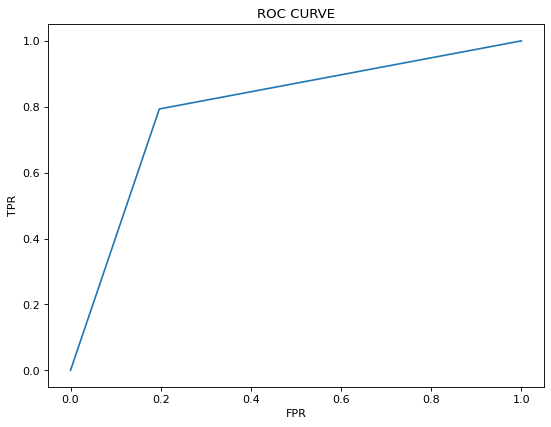

In [61]:
from sklearn.metrics import roc_curve
fpr, tpr, thresh1 = roc_curve(target, prediction, pos_label=1)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC CURVE')
plt.savefig('./ROC_CURVE')
plt.show()

## Draw Precision Recall Curve

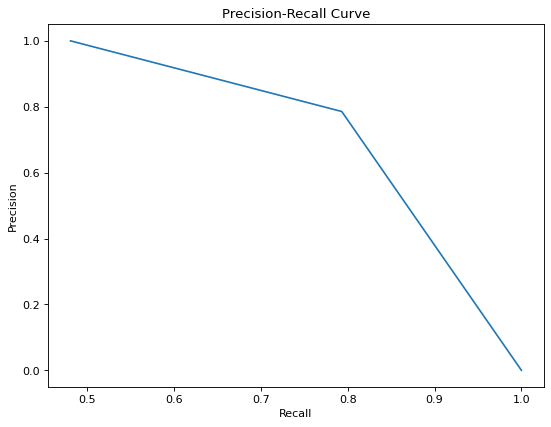

In [62]:
from  sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(prediction, target)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(precision,recall)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision-Recall Curve')
plt.savefig('./PRC_CURVE')
plt.show()